# Background
- This analysis is aim to predict which features of victims are importanct to survive in Titanic tragedy, which could be helpful for underwater tourism safty 
- This analysis is mainly to apply and compare different ensemble methods, and the data provided by Kaggle: https://www.kaggle.com/competitions/titanic/data

# Process
- 1. clean data: clean the missing rows in important feature, fill age null with median, ignore feature cabin with too many missing values
- 2. Explotary develop analysis: using plots and percentage tables to decide which features are important and should be put in the model
- 3. Pipeline: build pipeline with categorical features and numerical features, target variable is if survived
- 4. Modeling: try different ensemble modelling methods(Bagging, Ramdomforest, Extremely Randomized Trees, AdaBoost, GradientBoost, Voting), find the best model through evaluation

# Conclusion & Recommendation
## Conclusion:
- Female, and younger people with less parents or children aboard, embarked from Cherbourg, pay higher Passenger fare, in first and second Ticket class are more likely to survived based on the best performed Soft Voting model
- Soft Voting model performed best among different ensemble methods: 
- Accuracy:  0.7906976744186046
- F1_score:  0.7818352646414031
- Precision:  0.7818352646414031
- Recall:  0.7818352646414031
## Recommendation:
- If applicable, apply this Soft Votinng model to similar underwater tour to predict who may have lower possibility to survive
- More specific self-aid training and safty reminder for passengers from Cherbourg, male/elder passengers, and third ticket class passengers
- More resource allocate to help big family when emergency comes

In [171]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve
from sklearn.pipeline import Pipeline

In [172]:
df_train = pd.read_csv('/Users/junboli/Documents/Schulich/Fall 2023/Data Science 2/titanic/titanic/train.csv')
df_test= pd.read_csv('/Users/junboli/Documents/Schulich/Fall 2023/Data Science 2/titanic/titanic/test.csv')
#since test data misses imprtance column 'survived', we mainly use train data to predict

# Clean Data

In [173]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [174]:
df_train.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Braund, Mr. Owen Harris",male,NaN,NaN,NaN,347082,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


1. fill missing age with median age

In [175]:
# fill age na with median 
# Replace NaN values in the "age" column with the median of that column
median_age = df_train['Age'].median()
df_train['Age'].fillna(median_age, inplace=True)

2. check na in embarked, and drop the row with missing(not use cabin column because missing above 80% data)

In [176]:
df_train['Embarked'].isnull().sum()

2

In [177]:
df_train.drop(df_train[df_train['Embarked'].isnull()].index, axis=0, inplace=True)

3. check outliers

<Axes: xlabel='Survived', ylabel='Parch'>

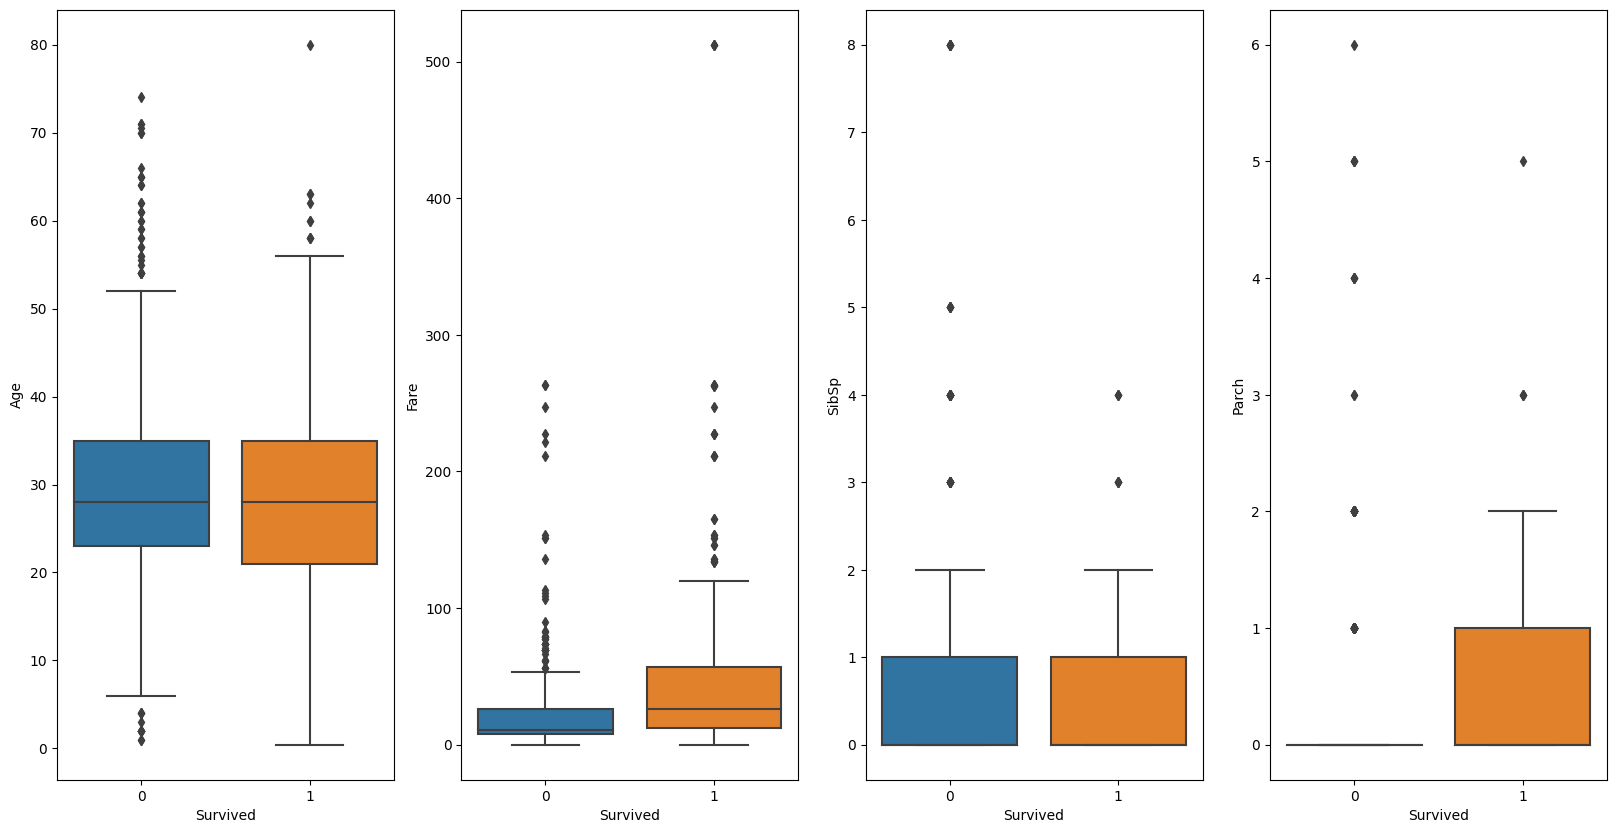

In [178]:
#sibling and parents/childern number could be diverse, so keep most of them
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4, figsize=(20,10))
sns.boxplot(x='Survived', y='Age', ax=ax1, data=df_train)
sns.boxplot(x='Survived', y='Fare', ax=ax2, data=df_train)
sns.boxplot(x='Survived', y='SibSp', ax=ax3, data=df_train)
sns.boxplot(x='Survived', y='Parch', ax=ax4, data=df_train)

In [179]:
#drop age above 70
drop_age_outliers = df_train[df_train['Age']>70].index
df_train.drop(drop_age_outliers, inplace=True)

In [180]:
#drop fare above 200
drop_fare_outliers = df_train[df_train['Fare']>200].index
df_train.drop(drop_fare_outliers, inplace=True)

In [181]:
#drop sibsp >5
drop_sibsp_outliers = df_train[df_train['SibSp']>5].index
df_train.drop(drop_sibsp_outliers, inplace=True)

In [182]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 857 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  857 non-null    int64  
 1   Survived     857 non-null    int64  
 2   Pclass       857 non-null    int64  
 3   Name         857 non-null    object 
 4   Sex          857 non-null    object 
 5   Age          857 non-null    float64
 6   SibSp        857 non-null    int64  
 7   Parch        857 non-null    int64  
 8   Ticket       857 non-null    object 
 9   Fare         857 non-null    float64
 10  Cabin        183 non-null    object 
 11  Embarked     857 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 87.0+ KB


In [183]:
df_train.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,857.000000,857.000000,857.000000,857,857,857.000000,857.000000,857.000000,857,857.000000,183,857
unique,NaN,NaN,NaN,857,2,NaN,NaN,NaN,666,NaN,134,3
top,NaN,NaN,NaN,"Braund, Mr. Owen Harris",male,NaN,NaN,NaN,347082,NaN,G6,S
freq,NaN,NaN,NaN,1,560,NaN,NaN,NaN,7,NaN,4,627
mean,445.061844,0.379230,2.339557,NaN,NaN,29.033454,0.460910,0.355893,NaN,26.057462,NaN,NaN
std,256.675018,0.485479,0.819013,NaN,NaN,12.651023,0.877377,0.784229,NaN,29.189264,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,224.000000,0.000000,2.000000,NaN,NaN,22.000000,0.000000,0.000000,NaN,7.895800,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,13.500000,NaN,NaN
75%,664.000000,1.000000,3.000000,NaN,NaN,35.000000,1.000000,0.000000,NaN,29.125000,NaN,NaN


# EDA

<Axes: xlabel='Survived', ylabel='Parch'>

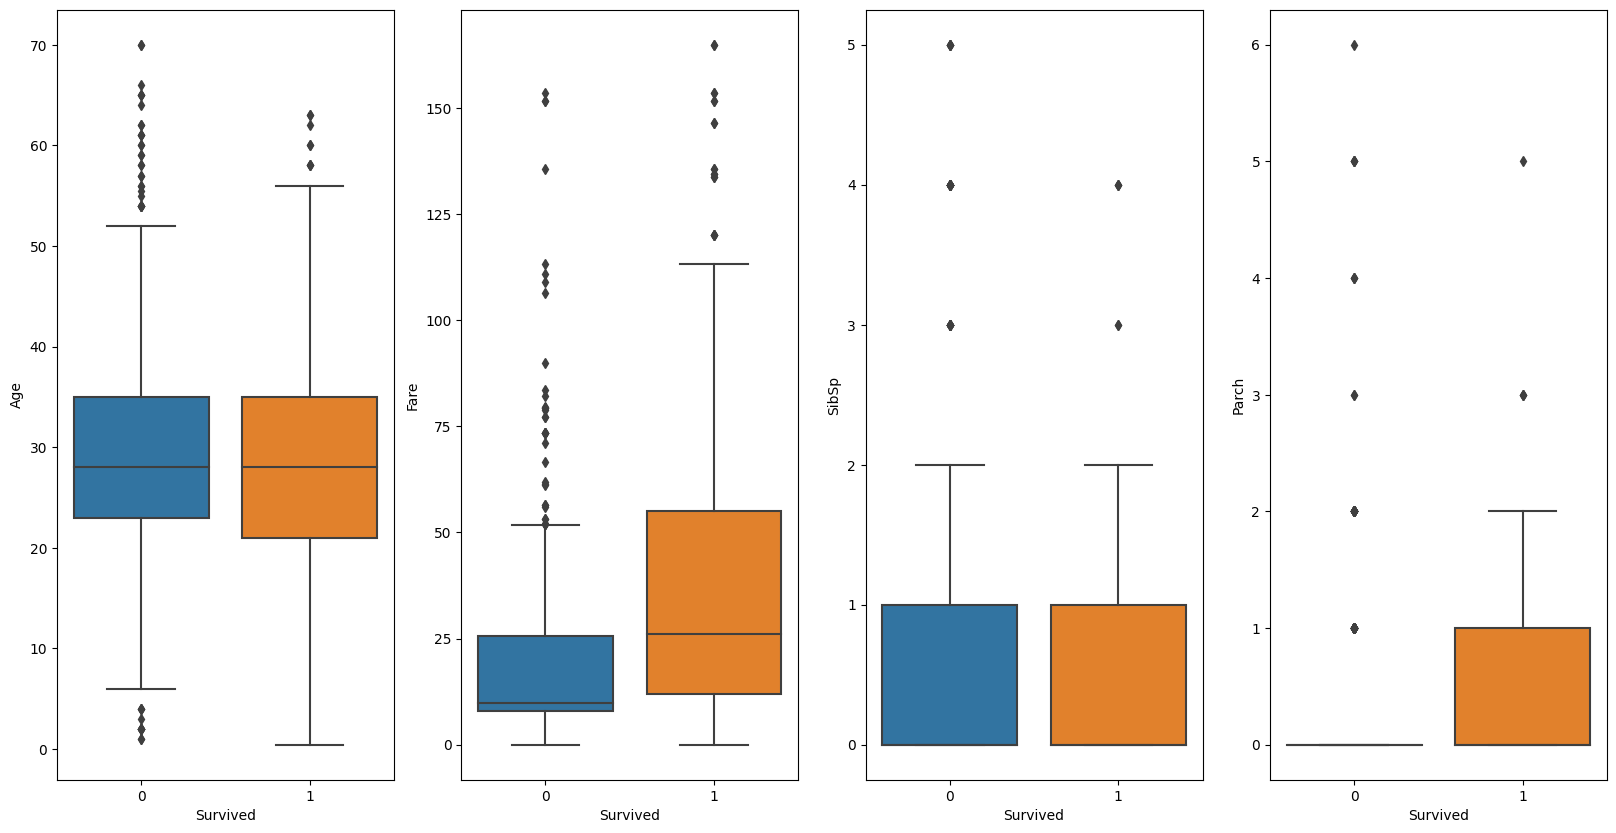

In [184]:
#fist see continous variables
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4, figsize=(20,10))
sns.boxplot(x='Survived', y='Age', ax=ax1, data=df_train)
sns.boxplot(x='Survived', y='Fare', ax=ax2, data=df_train)
sns.boxplot(x='Survived', y='SibSp', ax=ax3, data=df_train)
sns.boxplot(x='Survived', y='Parch', ax=ax4, data=df_train)

In [185]:
cross_tab = pd.crosstab(df_train['Survived'], df_train['Pclass'], margins=True, margins_name='Total')

# Calculate percentages
percentage_pclass = (cross_tab.div(cross_tab['Total'], axis=0) * 100).round(2)
percentage_pclass

Pclass,1,2,3,Total
Survived,,,,
0,13.53,18.23,68.23,100.0
1,36.62,26.77,36.62,100.0
Total,22.29,21.47,56.24,100.0


In [186]:
cross_tab = pd.crosstab(df_train['Survived'], df_train['Sex'], margins=True, margins_name='Total')

# Calculate percentages
percentage_Sex = (cross_tab.div(cross_tab['Total'], axis=0) * 100).round(2)
percentage_Sex

Sex,female,male,Total
Survived,,,
0,14.66,85.34,100.0
1,67.38,32.62,100.0
Total,34.66,65.34,100.0


In [187]:
cross_tab = pd.crosstab(df_train['Survived'], df_train['Embarked'], margins=True, margins_name='Total')

# Calculate percentages
percentage_embarked = (cross_tab.div(cross_tab['Total'], axis=0) * 100).round(2)
percentage_embarked

Embarked,C,Q,S,Total
Survived,,,,
0,13.16,8.65,78.20,100.0
1,25.85,9.23,64.92,100.0
Total,17.97,8.87,73.16,100.0


## Hypothesis: 
- these features should be considered in the model: Sex > Parch > Fare > Embarked > Pclass > Age

In [188]:
# Define the mapping for embarked
mapping = {'C': 1, 'Q': 2,'S':3}

# Convert the categorical columns to 0 and 1 using the map() function
cat_columns = ['Embarked']
df_train[cat_columns] = df_train[cat_columns].apply(lambda x: x.map(mapping))

In [189]:
# Define the mapping for for sex
mapping = {'male': 1, 'female': 0}

# Convert the categorical columns to 0 and 1 using the map() function
cat_columns = ['Sex']
df_train[cat_columns] = df_train[cat_columns].apply(lambda x: x.map(mapping))

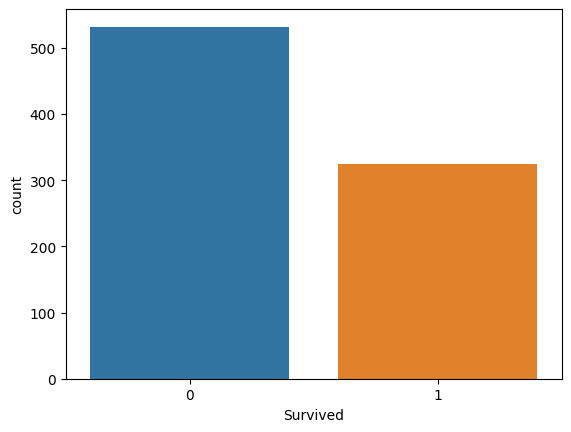

In [190]:
#imbalanced target variable
sns.countplot(x='Survived', data=df_train)
plt.show()

In [191]:
df_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,3
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,1
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,3
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,3
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,3
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",1,27.0,0,0,211536,13.0000,NaN,3
887,888,1,1,"Graham, Miss. Margaret Edith",0,19.0,0,0,112053,30.0000,B42,3
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",0,28.0,1,2,W./C. 6607,23.4500,NaN,3
889,890,1,1,"Behr, Mr. Karl Howell",1,26.0,0,0,111369,30.0000,C148,1


# Pipeline 

In [192]:
cat_columns = ['Sex', 'Pclass','Embarked']
num_columns = ['Age','Fare','Parch']
target = 'Survived'

# Separate features and target
X = df_train[cat_columns + num_columns]
y = df_train[target]

In [193]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [194]:
# Preprocessing
cat_transformer = OneHotEncoder(handle_unknown='ignore')
num_transformer = StandardScaler()

preprocessor = ColumnTransformer(transformers=[
    ('cat', cat_transformer, cat_columns),
    ('num', num_transformer, num_columns)
])

In [195]:
# Transform the train and test data
x_train_transformed = preprocessor.fit_transform(X_train)
x_test_transformed = preprocessor.fit_transform(X_test)
print(x_train_transformed.shape,x_test_transformed.shape)

(599, 11) (258, 11)


In [196]:
encoded_columns = list(preprocessor.named_transformers_['cat'].get_feature_names_out(cat_columns)) #encode categorical features, list tansfer..
all_feat = num_columns + encoded_columns #combine num and transfered categorical

X_train_transformed = pd.DataFrame(x_train_transformed, columns=all_feat)
X_test_transformed = pd.DataFrame(x_test_transformed, columns=all_feat)

# Ensemble Models

## 1. Bagging

In [197]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
bagging = BaggingClassifier(KNeighborsClassifier(),max_samples=0.5, max_features=0.5)

In [198]:
# Fit the models
bagging.fit(X_train, y_train)

# Evaluate on the test set
y_pred_bagging = bagging.predict(X_test)

In [199]:
print("Bagging Metrics: ")
print("Confusion Matrix: ", confusion_matrix(y_test, y_pred_bagging))
print("Accuracy: ", accuracy_score(y_test, y_pred_bagging))
print("F1_score: ", f1_score(y_test, y_pred_bagging, average='macro'))
print("Precision: ", precision_score(y_test, y_pred_bagging, average='macro'))
print("Recall: ", recall_score(y_test, y_pred_bagging, average='macro'))

Bagging Metrics: 
Confusion Matrix:  [[139  16]
 [ 46  57]]
Accuracy:  0.7596899224806202
F1_score:  0.732687165775401
Precision:  0.7660866345797852
Recall:  0.7250861259004071


## 2. RandomForest

In [200]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(n_estimators=10)

In [201]:
# Fit the models
clf_rf.fit(X_train, y_train)

# Evaluate on the test set
y_pred_rf = clf_rf.predict(X_test)

In [202]:
print("RandomForestClassifier Metrics: ")
print("Confusion Matrix: ", confusion_matrix(y_test, y_pred_rf))
print("Accuracy: ", accuracy_score(y_test, y_pred_rf))
print("F1_score: ", f1_score(y_test, y_pred_rf, average='macro'))
print("Precision: ", precision_score(y_test, y_pred_rf, average='macro'))
print("Recall: ", recall_score(y_test, y_pred_rf, average='macro'))

RandomForestClassifier Metrics: 
Confusion Matrix:  [[121  34]
 [ 28  75]]
Accuracy:  0.7596899224806202
F1_score:  0.7517999006951341
Precision:  0.7500769657040822
Recall:  0.7544002505480739


## 3. Extremely Randomized Trees¶

In [203]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier


clf_ert = ExtraTreesClassifier(n_estimators=10, max_depth=None,min_samples_split=2, random_state=0)
scores = cross_val_score(clf_ert, X, y, cv=5)
scores.mean() > 0.999

False

In [204]:
# Fit the models
clf_ert.fit(X_train, y_train)

# Evaluate on the test set
y_pred_ert = clf_ert.predict(X_test)

In [205]:
print("ExtremelyRandomizedTrees¶ Metrics: ")
print("Confusion Matrix: ", confusion_matrix(y_test, y_pred_ert))
print("Accuracy: ", accuracy_score(y_test, y_pred_ert))
print("F1_score: ", f1_score(y_test, y_pred_ert, average='macro'))
print("Precision: ", precision_score(y_test, y_pred_ert, average='macro'))
print("Recall: ", recall_score(y_test, y_pred_ert, average='macro'))

ExtremelyRandomizedTrees¶ Metrics: 
Confusion Matrix:  [[118  37]
 [ 35  68]]
Accuracy:  0.7209302325581395
F1_score:  0.7100399600399601
Precision:  0.7094304388422036
Recall:  0.7107422486689634


## 4. AdaBoost

In [206]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.ensemble import AdaBoostClassifier

clf_ada = AdaBoostClassifier(n_estimators=100)
scores = cross_val_score(clf_ada, X, y, cv=5)
scores.mean()

0.8051339589283286

In [207]:
# Fit the models
clf_ada.fit(X_train, y_train)

# Evaluate on the test set
y_pred_ada = clf_ada.predict(X_test)

In [208]:
print("AdaBoostClassifier¶ Metrics: ")
print("Confusion Matrix: ", confusion_matrix(y_test, y_pred_ada))
print("Accuracy: ", accuracy_score(y_test, y_pred_ada))
print("F1_score: ", f1_score(y_test, y_pred_ada, average='macro'))
print("Precision: ", precision_score(y_test, y_pred_ada, average='macro'))
print("Recall: ", recall_score(y_test, y_pred_ada, average='macro'))

AdaBoostClassifier¶ Metrics: 
Confusion Matrix:  [[121  34]
 [ 34  69]]
Accuracy:  0.7364341085271318
F1_score:  0.7252740369558409
Precision:  0.7252740369558409
Recall:  0.7252740369558409


# 5. GradientBoostingClassifier

In [209]:
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier

clf_gb = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0).fit(X_train, y_train)
clf_gb.score(X_test, y_test)

0.7441860465116279

In [210]:
# Fit the models
clf_gb.fit(X_train, y_train)

# Evaluate on the test set
y_pred_gb = clf_ada.predict(X_test)

In [211]:
print("GradientBoostingClassifier¶ Metrics: ")
print("Confusion Matrix: ", confusion_matrix(y_test, y_pred_gb))
print("Accuracy: ", accuracy_score(y_test, y_pred_gb))
print("F1_score: ", f1_score(y_test, y_pred_gb, average='macro'))
print("Precision: ", precision_score(y_test, y_pred_gb, average='macro'))
print("Recall: ", recall_score(y_test, y_pred_gb, average='macro'))

GradientBoostingClassifier¶ Metrics: 
Confusion Matrix:  [[121  34]
 [ 34  69]]
Accuracy:  0.7364341085271318
F1_score:  0.7252740369558409
Precision:  0.7252740369558409
Recall:  0.7252740369558409


## 6. Voting Classifier - hard

In [212]:
from sklearn import datasets
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
clf3 = GaussianNB()
clf4 = BaggingClassifier(KNeighborsClassifier(),max_samples=0.5, max_features=0.5)
clf5 = AdaBoostClassifier(n_estimators=100)
clf6 = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0).fit(X_train, y_train)
clf7 = DecisionTreeClassifier(max_depth=None, min_samples_split=2,random_state=0)
clf8 = KNeighborsClassifier()

eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3),('b', clf4),('ada', clf5),('gb', clf6),('dt', clf7),('knn', clf8)], voting='hard')

for clf, label in zip([clf1, clf2, clf3,clf4,clf5,clf6,clf7,clf8, eclf], ['Logistic Regression', 'Random Forest', 'naive Bayes', 'Bagging','AdaBoostClassifier','GradientBoostingClassifier','DecisionTreeClassifier','KNeighborsClassifier','Ensemble']):scores = cross_val_score(clf, X, y, scoring='accuracy', cv=5)
print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.81 (+/- 0.02) [Ensemble]


In [213]:
# Fit the models
eclf.fit(X_train, y_train)

# Evaluate on the test set
y_pred_eclf = eclf.predict(X_test)

In [214]:
print("VotingClassfier_hard¶ Metrics: ")
print("Confusion Matrix: ", confusion_matrix(y_test, y_pred_eclf))
print("Accuracy: ", accuracy_score(y_test, y_pred_eclf))
print("F1_score: ", f1_score(y_test, y_pred_eclf, average='macro'))
print("Precision: ", precision_score(y_test, y_pred_eclf, average='macro'))
print("Recall: ", recall_score(y_test, y_pred_eclf, average='macro'))

VotingClassfier_hard¶ Metrics: 
Confusion Matrix:  [[130  25]
 [ 32  71]]
Accuracy:  0.7790697674418605
F1_score:  0.7668785568219647
Precision:  0.7710262345679013
Recall:  0.7640150328844347


## 7. Voting Classifier - soft

In [215]:
eclf_soft = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3),('b', clf4),('ada', clf5),('gb', clf6),('dt', clf7),('knn', clf8)],
                        voting='soft', weights=[1, 2, 1,2,2,2,1,1]) #give ensemble models higher weight


In [216]:
# Fit the models
eclf_soft.fit(X_train, y_train)

# Evaluate on the test set
y_pred_eclf = eclf_soft.predict(X_test)

In [217]:
print("VotingClassfier_soft¶ Metrics: ")
print("Confusion Matrix: ", confusion_matrix(y_test, y_pred_eclf))
print("Accuracy: ", accuracy_score(y_test, y_pred_eclf))
print("F1_score: ", f1_score(y_test, y_pred_eclf, average='macro'))
print("Precision: ", precision_score(y_test, y_pred_eclf, average='macro'))
print("Recall: ", recall_score(y_test, y_pred_eclf, average='macro'))

VotingClassfier_soft¶ Metrics: 
Confusion Matrix:  [[128  27]
 [ 28  75]]
Accuracy:  0.7868217054263565
F1_score:  0.77742922123755
Precision:  0.7779034690799397
Recall:  0.7769808957093642


Soft Voting performed best among all the ensemble models